<img src="https://teaching.bowyer.io/SDSAI/0/img/IMPERIAL_logo_RGB_Blue_2024.svg" alt="Imperial Logo" width="500"/><br /><br />

Ensemble Methods and Unsupervised Learning
==============
### SURG70098 - Surgical Data Science and AI
### Stuart Bowyer

## Intended Learning Outcomes
1.  Understand and apply the two common ensemble learning methods (bagging and boosting)
1.  Can address class imbalances
1.  Can describe what is meant by unsupervised learning and why it is useful
1.  Have an understanding of clustering methods and be able to apply them to data
1.  Be aware of the concepts behind dimensionality reduction and when/how to apply it

## MIMIC Dataset
The following code will load the datasets used in this lecture notes

In [25]:
%pip install pandas_gbq

import pandas as pd
import pandas_gbq

project_id = 'mimic-project-439314'  # @param {type:"string"}

df_day1_vitalsign = pandas_gbq.read_gbq("""
  SELECT
    *,
    (dod IS NOT NULL) AND (dod <= dischtime) AS mortality,
    weight / POWER(height/100, 2) > 30 AS obese
  FROM `physionet-data.mimiciv_derived.first_day_vitalsign`
  LEFT JOIN (
    SELECT
      subject_id,
      stay_id,
      gender,
      race,
      dischtime,
      admission_age,
      dod
    FROM
      `physionet-data.mimiciv_derived.icustay_detail`
  )
  USING(subject_id, stay_id)
  LEFT JOIN (
    SELECT
      stay_id,
      AVG(weight) as weight
    FROM
      `physionet-data.mimiciv_derived.weight_durations`
    GROUP BY
      stay_id
  )
  USING(stay_id)
  LEFT JOIN (
    SELECT
      stay_id,
      CAST(AVG(height) AS FLOAT64) AS height
    FROM
      `physionet-data.mimiciv_derived.height`
    GROUP BY
      stay_id
  )
  USING(stay_id)
  WHERE heart_rate_mean IS NOT NULL
""", project_id=project_id)

# Ensemble Methods

## Introduction to Ensemble Methods
*   You probably have noticed that different models have different advantages and disadvantages
*   i.e. sometimes they work well, others they do not
*   Ensemble methods combine models together to improve overall performance by ...
    *   Improving accuracy
    *   Improving stability
    *   Reducing error

**How would you combine models together to optimise their group performance?**

## Bias and Variance
*   **Bias:** when a model makes incorrect predictions due to incorrect assumptions (i.e. assuming linearity). Also called: **underfitting**
*   **Variance:** when a model makes incorrect predictions due to sensitivity to small fluctuations (i.e. complex model on noisy data). Also called: **overfitting**

There is typically a **trade off** between these two aspects of a model

For example:
*   Shallow decision trees are prone to high bias
*   Deep decision trees are prone to high variance


## Bootstrap Aggregating (Bagging)
*   Builds multiple parallel models independently using random (possibly overlapping) subsets of the data and combines their predictions
*   Aim is to reduce variance (overfitting)
*   Two components:
    *   **Bootstrapping:** a random sample (with replacement) of the data is used to train several **weak learners**
    *   **Aggregation:** the output of the weak learners is combined to give a single output

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Ensemble_Bagging.svg" alt="Description of Image" style="height: 400px; display: block; margin: 0 auto;">

By <a href="//commons.wikimedia.org/wiki/User:Sirakorn" title="User:Sirakorn">Sirakorn</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=85888768">Link</a>

### Random Forests
*   Very commonly used with decision trees to create **random forests**
*   Add the additional step of randomly selecting a subset of features for training each tree
*   `from sklearn.ensemble import RandomForestClassifier`


<img src="https://upload.wikimedia.org/wikipedia/commons/7/76/Random_Forest_Diagram_Extra_Wide.png" alt="Description of Image" style="height: 400px; display: block; margin: 0 auto;">

By <a href="//commons.wikimedia.org/w/index.php?title=User:CollaborativeGeneticist&amp;action=edit&amp;redlink=1" class="new" title="User:CollaborativeGeneticist (page does not exist)">CollaborativeGeneticist</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=113209159">Link</a>

## Boosting
*   Builds sequential models that try to correct the errors of the predecessor
*   Aim is to reduce bias (underfitting) (due to weak models) by focusing models on the errors of other models

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b5/Ensemble_Boosting.svg" alt="Description of Image" style="height: 400px; display: block; margin: 0 auto;">

By <a href="//commons.wikimedia.org/wiki/User:Sirakorn" title="User:Sirakorn">Sirakorn</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=85888769">Link</a>

### Gradient Boosted Trees
*   Very commonly used with decision trees to create **gradient boosted trees**
*   `from sklearn.ensemble import GradientBoostingClassifier`
*   Popular alternative implementation is 'XGBoost (eXtreme Gradient Boosting)' which includes regularisation


# Class Imbalance

## Problem
*   One of the common issues you will often face with adverse clinical outcomes is class imbalances
*   i.e. when one of your predicted classes is much more/less common than the others
*   For example, in the MIMIC dataset ...

In [100]:
df_day1_vitalsign.mortality.value_counts(normalize=True)

mortality
False    0.883693
True     0.116307
Name: proportion, dtype: Float64

*   This imbalance can cause training bias and poor performance

### Can you suggest how to address the class imbalance?

### Oversampling
*   Involves creating new observations in the minority class by ...
*   **Random oversampling:** randomly duplicating entries from the minority class
*   **Synthetic Minority Oversampling Technique (SMOTE):** generating new synthetic samples in the minority class by interpolating between existing observations

#### Random Oversampling
Increases size of minority dataset, but can lead to overfitting

![Random Oversampling](https://teaching.bowyer.io/SDSAI/6/img/Illustrations-SDSAI-06_Random-Oversampling.svg)

#### Synthetic Minority Oversampling Technique (SMOTE)
Reduces risk of overfitting, but issues remain with:
*   Non-ordinal categorical data
*   Noise amplification
*   Dimensionality

![SMOTE](https://teaching.bowyer.io/SDSAI/6/img/Illustrations-SDSAI-06_SMOTE-Oversampling.svg)

### Undersampling
*   Involves dropping observations in the majority class by ...
*   **Random undersampling:** randomly removing entries from the majority class
*   **Tomek links:** removes entries from the majority class that are close to the minority class (i.e. suspected noise)
*   **NearMiss:** removes entries from the majority class that are far from the minority class (i.e. easy classifications)


![Undersampling](https://teaching.bowyer.io/SDSAI/6/img/Illustrations-SDSAI-06_Undersampling.svg)

### Using `imbalanced-learn`
*   Python has a package (parallelling `scikit-learn`) for addressing imbalanced datasets
    *    [Oversampling methods](https://imbalanced-learn.org/stable/references/over_sampling.html)
    *    [Undersampling methods](https://imbalanced-learn.org/stable/references/over_sampling.html)

In [111]:
from imblearn.over_sampling import RandomOverSampler

data = df_day1_vitalsign.dropna(subset=['admission_age', 'heart_rate_mean', 'sbp_mean', 'glucose_mean', 'mortality'])
X = data[['admission_age', 'heart_rate_mean', 'sbp_mean', 'glucose_mean']]
Y = data['mortality']

# Create the random oversampler
ros = RandomOverSampler(random_state=1)

# Apply it to our dataset
X_res, Y_res = ros.fit_resample(X, Y)

print("Previous value counts: ", Y.value_counts().to_list())
print("Resampled value counts:", Y_res.value_counts().to_list())

Previous value counts:  [63076, 8034]
Resampled value counts: [63076, 63076]


## Exercise 6.1 - Supervised Learning Challenge
Use the [Wisconsin Breast Cancer Database](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) to build the most high performance classifier for predicting tumour malignancy from breast mass features.

98% accuracy is possible

There are instructions on importing the dataset to Python on the above page.

I suggest starting with logistic regression on a subset of features, but you should expect to build up the model complexity and number of features.

You will probably want to use most of the techniques you have learnt in the past two/three lectures:
*   Some basic EDA of this new dataset
*   Ensuring the data are fully prepared
*   Exploring different classification methods
*   Searching for optimal parameters
*   Addressing class imbalances
*   Testing other performance improvements (ensemble methods)
*   Using effective model validation

**Before you start, what metric/s should we use?**

# Unsupervised Learning

## Introduction
*   **What:** A type of machine learning where the algorithm is trained on data without labeled outcomes
*   **Why:** The goal is to uncover hidden patterns, structures, or relationships in the data **WITHOUT NEEDING LABELS**
*   **Methods:**
    *   **Clustering:** learning groups in the data based on common feature patterns
    *   **Dimensionality Reduction:** learning simplified representations of data based on removing redundant information

## Clustering
*   **What:** learning groupings in the data based on common feature patterns
*   **Why:** reveals complex structure that is unclear from simple analyses
*   **Uses:**
    *   Identifying phenotypes of complex disease subtypes (e.g. in cardiac disease "young-low comorbidity burden; metabolic; cardio-renal; etc," - https://link.springer.com/article/10.1007/s11897-023-00615-z)
    *   Segmenting structures from medical images
    *   Grouping patients to predict prognosis or recovery time

### Clustering Methods
*   **Centroid-Based Methods:** assign clusters based on proximity to a given centroid (e.g. K-Means)
*   **Hierarchical Methods:** build clusters in a hierarchy by recursively either combining (e.g. agglomerative) or splitting (e.g. divisive) clusters
*   **Density-Based Methods:** identify clusters based on contiguous areas of high-density data surrounded by low density data (e.g. DBSCAN)

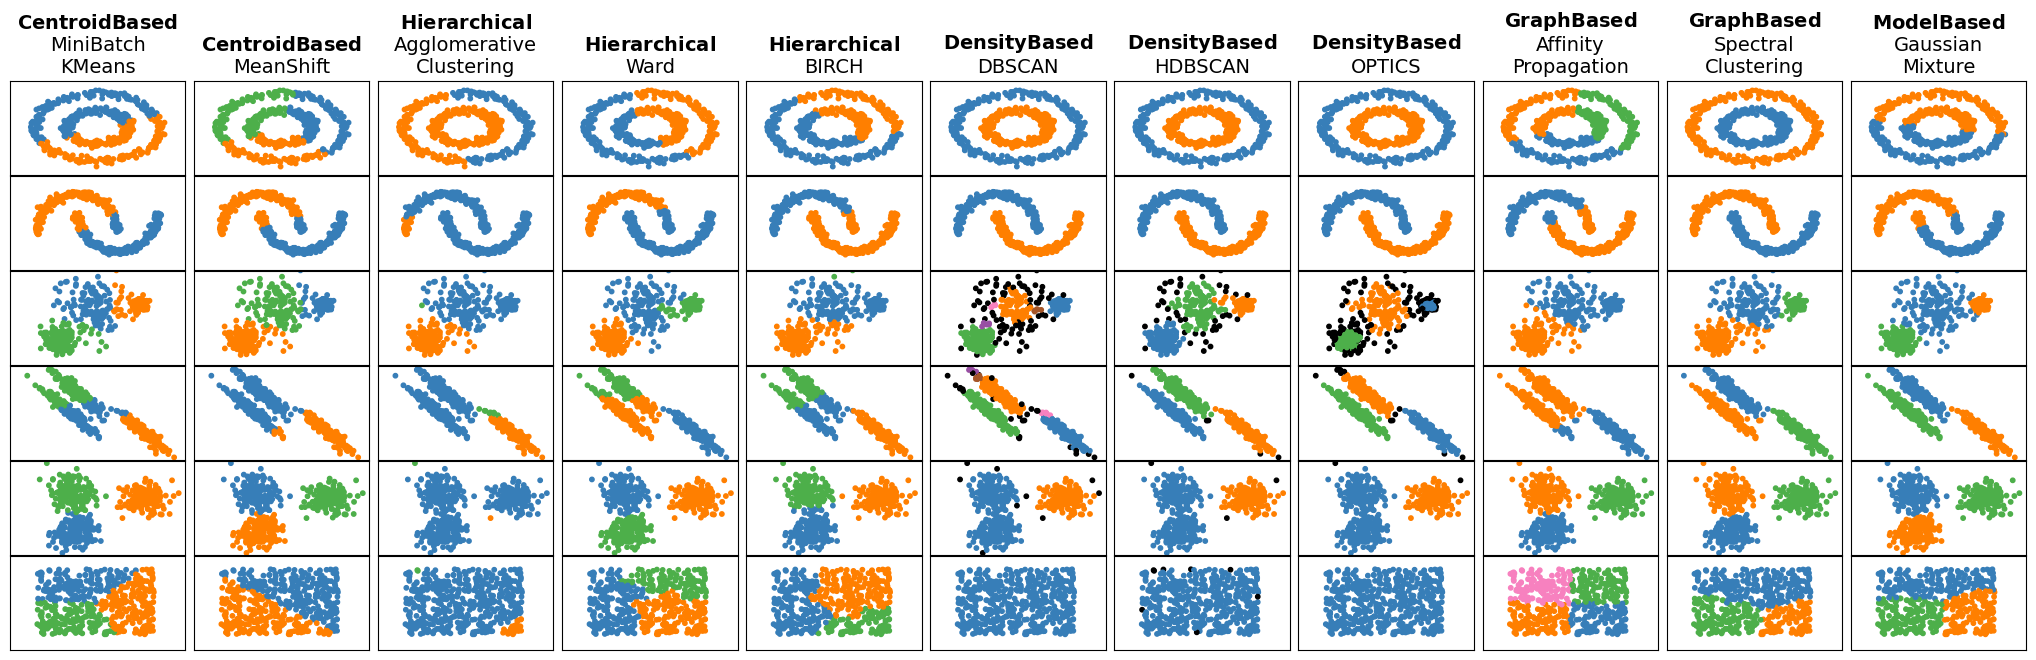

In [23]:
# Taken from: https://scikit-learn.org/1.5/auto_examples/cluster/plot_cluster_comparison.html

import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 6))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("$\\bf{CentroidBased}$\nMiniBatch\nKMeans", two_means),
        ("$\\bf{CentroidBased}$\nMeanShift", ms),
        ("$\\bf{Hierarchical}$\nAgglomerative\nClustering", average_linkage),
        ("$\\bf{Hierarchical}$\nWard", ward),
        ("$\\bf{Hierarchical}$\nBIRCH", birch),
        ("$\\bf{DensityBased}$\nDBSCAN", dbscan),
        ("$\\bf{DensityBased}$\nHDBSCAN", hdbscan),
        ("$\\bf{DensityBased}$\nOPTICS", optics),
        ("$\\bf{GraphBased}$\nAffinity\nPropagation", affinity_propagation),
        ("$\\bf{GraphBased}$\nSpectral\nClustering", spectral),
        ("$\\bf{ModelBased}$\nGaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()

Modified from https://scikit-learn.org/1.5/auto_examples/cluster/plot_cluster_comparison.html

### K-Means Clustering
*   Centroid-based method assigns clusters based on proxmity to a given centroid
*   **Centroid:** the centre of the cluster
*   **Distance metric:** the numerical value defining how the 'proximity' between a data point and a centroid

![K-Means](https://teaching.bowyer.io/SDSAI/6/img/Illustrations-SDSAI-06_K-Means-Clustering.svg)

**Can you think of some types of cluster where this would not work well?**

#### Properties of K-Means Clustering
| **Advantages**                              | **Disadvantages**                                       |
|---------------------------------------------|-------------------------------------------------------|
| Simple and easy to implement                | Requires the number of clusters (\(k\)) to be predefined |
| Computationally efficient for large datasets| Sensitive to the initial choice of centroids          |
| Works well with spherical cluster shapes    | Struggles with clusters of varying sizes or densities |
| Easily interpretable results                | Prone to convergence to local minima                 |
| Scales well to higher-dimensional data      | Affected by outliers, which can distort cluster centroids |


#### K-Means in `scikit-learn`
**What has gone wrong here?**

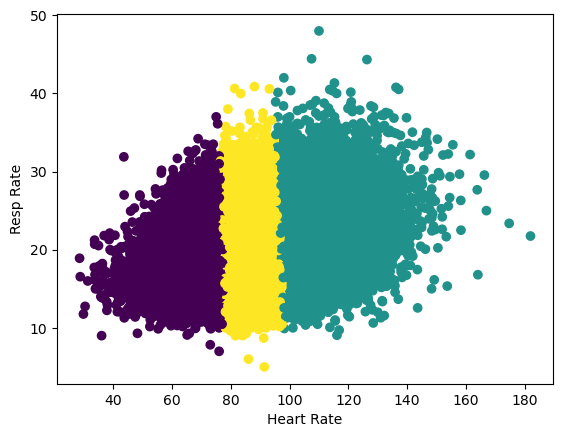

In [244]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select the two columns for analysis
X = df_day1_vitalsign[['heart_rate_mean', 'resp_rate_mean']].dropna().to_numpy()

# # Standardisation (try adding this in ...)
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# Create and fit the cluster
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X)

# Predict the cluster labels
labels = kmeans.predict(X)

# Plot the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.xlabel('Heart Rate')
plt.ylabel('Resp Rate')
plt.show()

## Dimensionality Reduction
*   **What:** learning simplified representations of data based on removing redundant information
*   **Why:** reducing 'curse of dimensionality' and understanding feature importance and 
*   **Uses:**
    *   Simplifying genomic data - https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0093766
    *   Simplifying timeseries data - https://link.springer.com/article/10.1007/s11227-021-04303-4

### Feature Selection
*   **What:** completely removing one or more features that do not contribute 'useful information'
*   As covered in previous reading for supervised learning
*   **How:** various methods available that remove features with:
    *   Low variance (i.e. features that do not change much)
    *   High correlation (i.e. two features represent the same physical characteristic)
    *   High mutual information (i.e. two features with high dependency or high shared information)

### Feature Projection
*   **What:** combining multiple features together in such a way that they are still informative, but in fewer dimensions
*   **How:** 'projecting' data points into a lower-dimensional space 

![Feature Projection](https://teaching.bowyer.io/SDSAI/6/img/Illustrations-SDSAI-06_Feature-Projection.svg)

#### Principal Component Analysis (PCA)

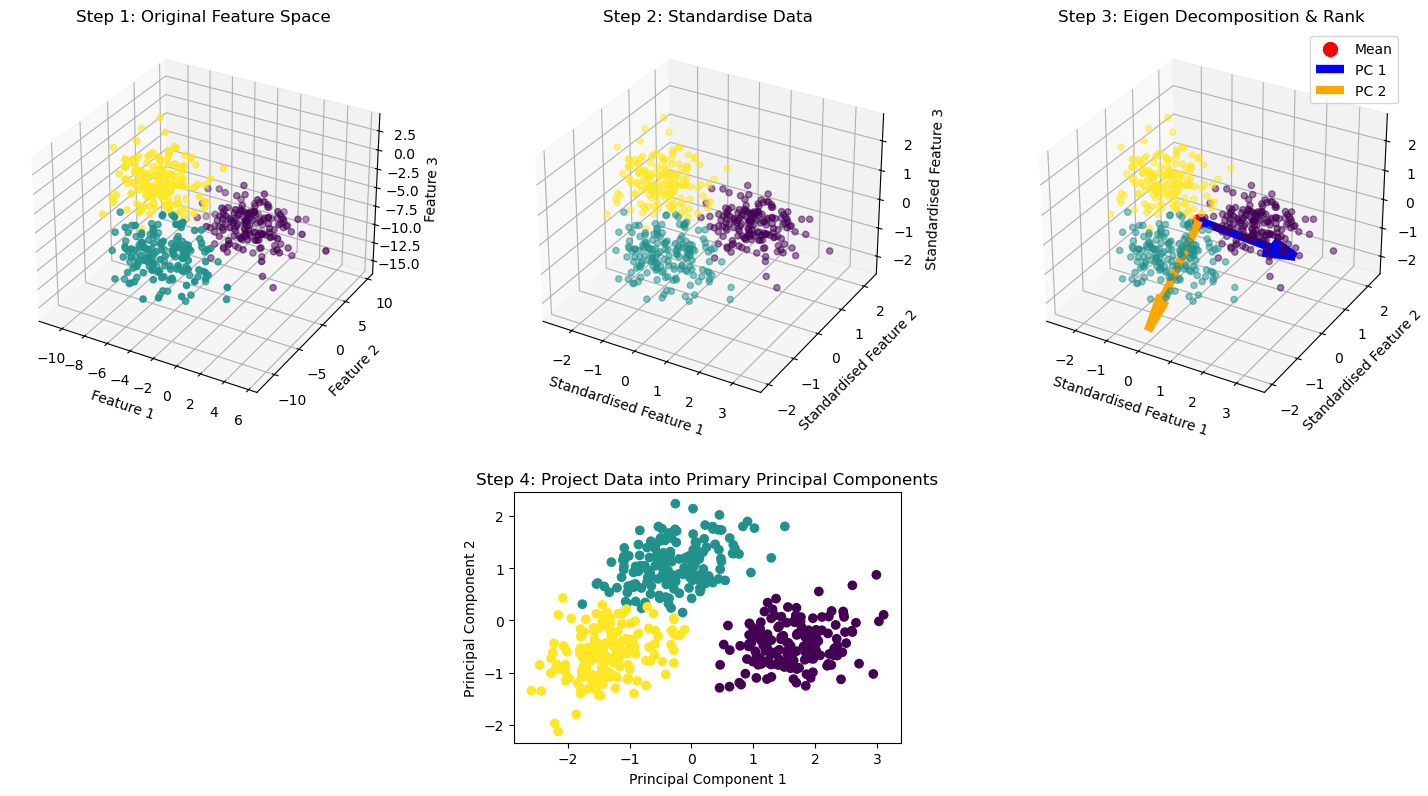

In [192]:
# This code is just for the explanatory plot, you do not need to understand it
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec

# Generate synthetic 3D data
X, y = make_blobs(n_samples=500, centers=3, n_features=3, random_state=1, cluster_std=2.0)

# Step 1: Original 3D data visualization
fig = plt.figure(figsize=(18, 10))

gs = GridSpec(2, 3, height_ratios=[2, 1])
gs.update(wspace=0.3, hspace=0.05)

ax1 = fig.add_subplot(gs[0,0], projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax1.set_title("Step 1: Original Feature Space")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Feature 3")

# Step 2: Standardise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ax2 = fig.add_subplot(gs[0,1], projection='3d')
ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y, alpha=0.5)
ax2.set_title("Step 2: Standardise Data")
ax2.set_xlabel("Standardised Feature 1")
ax2.set_ylabel("Standardised Feature 2")
ax2.set_zlabel("Standardised Feature 3")

# Step 3: Compute PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Extract eigenvectors (principal components) and mean
mean = np.mean(X_scaled, axis=0)
components = pca.components_

# Visualize principal components in 3D space
ax3 = fig.add_subplot(gs[0,2], projection='3d')
ax3.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y, alpha=0.5)
ax3.scatter(mean[0], mean[1], mean[2], color='red', s=100, label='Mean')
for i, component in enumerate(components):
    ax3.quiver(
        mean[0], mean[1], mean[2], 
        component[0], component[1], component[2],
        color=['blue', 'orange'][i], length=3.0, linewidth=6, label=f'PC {i + 1}'
    )
ax3.set_title("Step 3: Eigen Decomposition & Rank")
ax3.set_xlabel("Standardised Feature 1")
ax3.set_ylabel("Standardised Feature 2")
ax3.set_zlabel("Standardised Feature 3")
ax3.legend()

# Step 4: Project data onto the first two principal components
X_pca = pca.transform(X_scaled)

ax4 = fig.add_subplot(gs[1,1])
ax4.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
# ax4.set_aspect('equal')
ax4.set_title("Step 4: Project Data into Primary Principal Components")
ax4.set_xlabel("Principal Component 1")
ax4.set_ylabel("Principal Component 2")

# Show
# Reduce the vertical space between rows
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()


#### PCA in `scikit-learn`

In [242]:
%%capture out
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select the two columns for analysis
X = df_day1_vitalsign[['heart_rate_max', 'heart_rate_mean', 'heart_rate_min']].dropna().to_numpy()

# Create and fit the PCA
pca = PCA(n_components=2)
pca.fit(X)

# Print the Explained Variance Ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Transform the data
X_trans = pca.transform(X)

# Plot the Full Heart Rate Data
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.2)
ax1.set_xlabel("Max HR")
ax1.set_ylabel("Mean HR")
ax1.set_zlabel("Min HR")

# Plot the Dimension Reduced Data
ax2 = fig.add_subplot(122)
ax2.scatter(X_trans[:, 0], X_trans[:, 1])
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
plt.show()

#### Output

Explained variance ratio: [0.84141058 0.14222821]


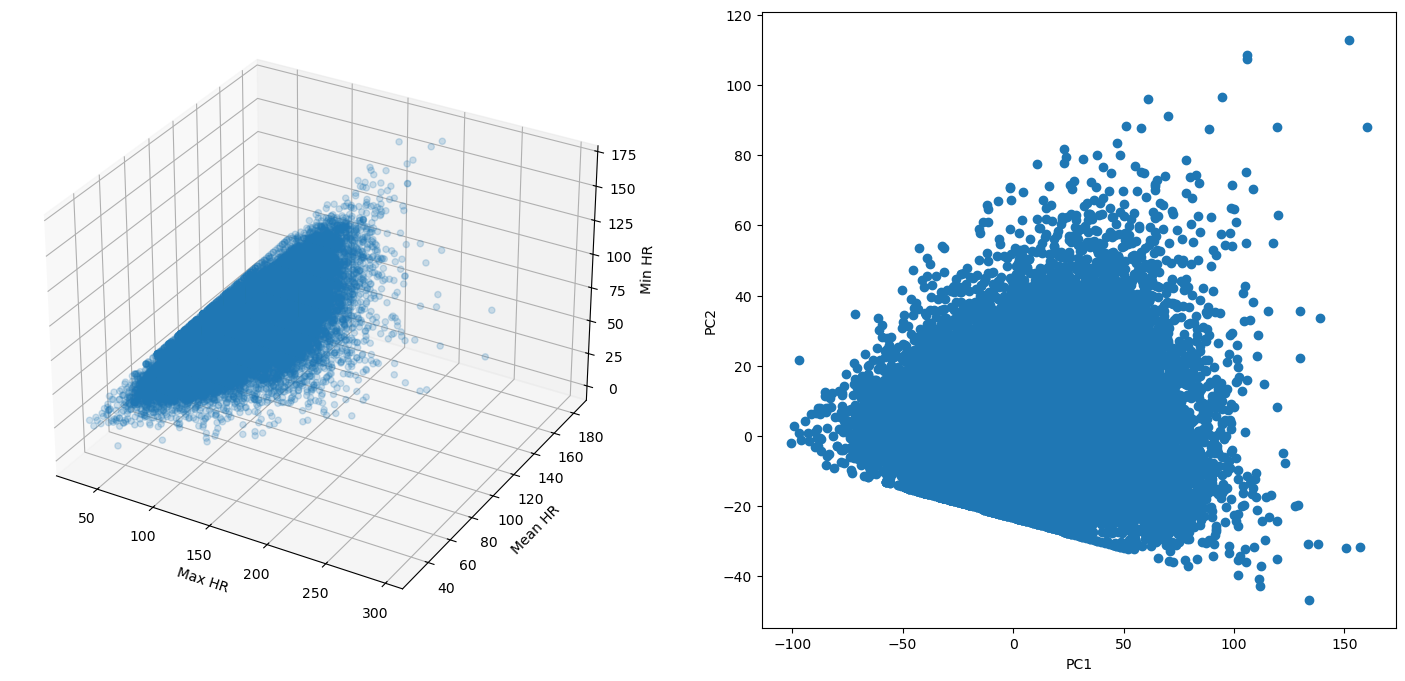

In [243]:
out.show()

## Exercise 6.2 - Unsupervised Clustering of the Wisconsin Breast Cancer Database
Use K-means clustering to cluster **only the features** from the Wisconsin Breast Cancer Database, that we used earlier for supervised learning.

First try with 2, then increase the number of clusters.

Once you have generated a cluster do some very basic EDA to explore how your clusters associate with the tumour type (output variable).

What do you notice about these clusters?

What does this suggest about the tumour types?

## Exercise 6.3 - Dimensionality Reduction of the Wisconsin Breast Cancer Database
Use the PCA dimensionality reduction method to see how many dimensions you can reduce from the Wisconsin Breast Cancer Database before the performance of your classifier from Exercise 6.1 loses a lot of performance.

Start by reducing the dimensionality by 1 and compute the classifier's performance, then keep reducing the dimensionality.

You should then produce a plot of 'number of dimensions' against 'classifier performance'.

# Wrap Up
*   You now have lots of tools to address supervised and unsupervised machine learning problems; however, experience and reading up on the nuances of each method is the difference between using them well
*   Data preparation is critically important to model performance
*   Consider the bias-variance trade offs
*   REMEMBER... if your model does not have the key features of the system/disease/procedure/etc. you are trying to predict, no matter how complex you make your model or how many samples you collect, it will never improve its performance

<img src="https://assets.cureus.com/uploads/figure/file/292667/article_river_6a398820513311ecb45235ba7f0fde7e-LRvsNN_plot4.png" alt="Description of Image" style="height: 400px; display: block; margin: 0 auto;">

Issitt R W, Cortina-Borja M, Bryant W, et al. (February 21, 2022) Classification Performance of Neural Networks Versus Logistic Regression Models: Evidence From Healthcare Practice. Cureus 14(2): e22443. doi:10.7759/cureus.2244

## Self Study

### New Material
*   Detail on Gradient Boosting / XGboost - https://xgboost.readthedocs.io/en/stable/tutorials/model.html
*   Silhouette scoring of cluster separation - https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
*   t-SNE (t-distributed Stochastic Neighbor Embedding) tutorial - https://www.datacamp.com/tutorial/introduction-t-sne

### Consolidation Reading
*   Original SMOTE Oversampling Method - https://arxiv.org/pdf/1106.1813
*   Boosting and Bagging Paper - https://www.d.umn.edu/~rmaclin/cs5751/notes/opitz-jair99.pdf
*   Survey article on using clustering for discovering clinical phenotypes in cardiac disease - https://link.springer.com/article/10.1007/s11897-023-00615-z
*   `scikit-learn`'s high-level overview of clustering methods - https://scikit-learn.org/1.5/modules/clustering.html